# Exploring Water Quality Complaints

I noticed a number of times during the winter that there was dark water flowing from our sink's faucet.  Not for very long, just a few seconds and usually when the water temperature was set to hot, but I hadn't noticed this at all in the summer.  I wondered if water complaints like this might be more common in the colder months, when there is presumably more damage to pipes from freezing weather.  I decided to try to find some water quality data for the city and explore it for possible seasonal fluctuations or other patterns.

I started by downloading the dataset as a csv.  To work with the data, I decided to use Python 3 in a Jupyter notebook.  To begin, I wanted to visualize the data and answer a few basic questions about it.

----------------------------------------------------------------------------------------------


### Import packages

In [27]:
import numpy
import scipy
import matplotlib
import sklearn
import pandas as pd
import itertools
import gensim
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# Import some packages to help parse the dates
import datetime as dt
import matplotlib.dates as mdates
import matplotlib.pyplot as plt # matplotlib plots
import matplotlib.gridspec as gridspec # for subplots
import plotly.plotly as py
from plotly.graph_objs import *
import plotly.tools as tls
%matplotlib inline

### Import data and check out the structure

In [28]:
df = pd.read_csv('Water_Quality_complaints.csv')
df.head(2)

,Unique Key,Created Date,Closed Date,Agency,Agency Name,Complaint Type,Descriptor,Location Type,Incident Zip,Incident Address,...,Bridge Highway Name,Bridge Highway Direction,Road Ramp,Bridge Highway Segment,Garage Lot Name,Ferry Direction,Ferry Terminal Name,Latitude,Longitude,Location
0,31503046,9/10/15,10/30/15,DEP,Department of Environmental Protection,Water Quality,Clear Water With Other Particles (Use Comments...,NaN,11213.0,1534 PROSPECT PLACE,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.672986,-73.925914,"(40.6729859224145, -73.92591381590103)"
1,31539143,9/15/15,9/29/15,DEP,Department of Environmental Protection,Water Quality,Cloudy Or Milky Water (QB1),NaN,10025.0,840 COLUMBUS AVENUE,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.796219,-73.965090,"(40.79621920145586, -73.96508964870316)"


In [29]:
census = pd.read_csv('New_York_City_Population_By_Boroughs.csv')
census.head(2)

,Borough,2000 Population,2010 Population
0,Bronx,1332650,1385108
1,Brooklyn,2465326,2504700


In [30]:
# df.describe()
list(df) # column headings

['Unique Key',
 'Created Date',
 'Closed Date',
 'Agency',
 'Agency Name',
 'Complaint Type',
 'Descriptor',
 'Location Type',
 'Incident Zip',
 'Incident Address',
 'Street Name',
 'Cross Street 1',
 'Cross Street 2',
 'Intersection Street 1',
 'Intersection Street 2',
 'Address Type',
 'City',
 'Landmark',
 'Facility Type',
 'Status',
 'Due Date',
 'Resolution Action Updated Date',
 'Community Board',
 'Borough',
 'X Coordinate (State Plane)',
 'Y Coordinate (State Plane)',
 'Park Facility Name',
 'Park Borough',
 'School Name',
 'School Number',
 'School Region',
 'School Code',
 'School Phone Number',
 'School Address',
 'School City',
 'School State',
 'School Zip',
 'School Not Found',
 'School or Citywide Complaint',
 'Vehicle Type',
 'Taxi Company Borough',
 'Taxi Pick Up Location',
 'Bridge Highway Name',
 'Bridge Highway Direction',
 'Road Ramp',
 'Bridge Highway Segment',
 'Garage Lot Name',
 'Ferry Direction',
 'Ferry Terminal Name',
 'Latitude',
 'Longitude',
 'Location']

### What kinds of complaints are people making? 

In [31]:
sorted(df['Descriptor'].unique())

['BWSO Referral To Water Quality (For DEP Internal Use Only)',
 'Clear Water With Organisms (Insects, Worms) (QE2)',
 'Clear Water With Other Particles (Use Comments) (QEZ)',
 'Cloudy Or Milky Water (QB1)',
 'Cloudy Or Milky, Other (Use Comments) (QBZ)',
 'Defective Water Sampling Station (QSS)',
 'No Sampling Required, Requested Information (QG2)',
 'Oil, Grease In Water (QD1)',
 'Other Water Problem (Use Comments) (QZZ)',
 'Taste/Odor - Musty/Stale',
 'Taste/Odor, Bitter/Metallic (QA3)',
 'Taste/Odor, Chemical (QA2)',
 'Taste/Odor, Chlorine (QA1)',
 'Taste/Odor, Musty/Stale (QA4)',
 'Taste/Odor, Sewer (QA5)',
 'unknown odor/taste in drinking water (QA6)']

In [32]:
# For consistency of notation, let's change all entries with descriptor 
# "Taste/Odor - Musty/Stale" to "Taste/Odor - Musty/Stale (QA4)" 
df['Descriptor'] = df['Descriptor'].str.replace('Taste/Odor - Musty/Stale','Taste/Odor, Musty/Stale (QA4)' )

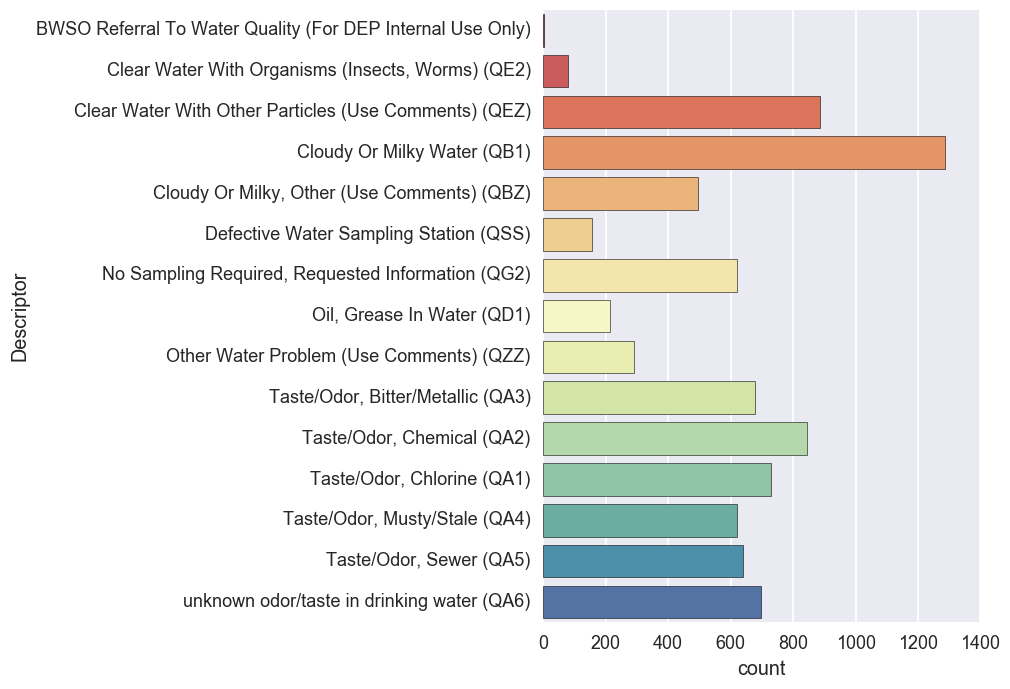

In [33]:
num_colors = df['Descriptor'].nunique()
sns.set_context("talk")
countPlot = sns.countplot(y='Descriptor',
             data=df.sort_values(by='Descriptor'), 
             palette = sns.color_palette('Spectral',num_colors))

fig = countPlot.get_figure()
plt.tight_layout()
fig.savefig('what_complaints.png')

### Water Complaints By Geographical Area

Question: Where are water quality complaints coming from in the city?

One way to visualize the complaints geographically is to plot a scatter of the complaints by location (latitude and longitude).  Let's see if the incidents appear to cluster by latitude & longitude: 


#### Water complaints plotted by latitude and longitude.

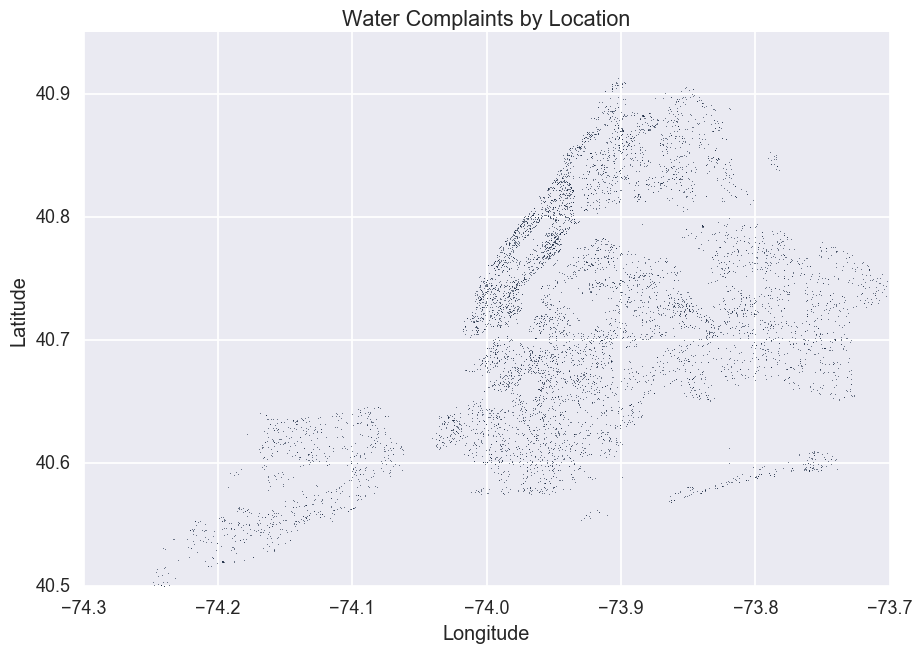

In [52]:
latlong_fig = plt.figure()
plt.plot(df['Longitude'], df['Latitude'], linestyle='', marker='o', markersize=0.5)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Water Complaints by Location')
plt.show()

latlong_fig.savefig('by_location.png')

We can immediately see that the scattered data seem to come from all 5 boroughs: we can see the shapes of the Bronx and Manhattan (NW blob), Queens and Brooklyn (central/E blob, and SE strip corresponding to The Rockaways barrier islands), and Staten Island (SW).

We can color-code the map by borough to make it clearer which complaints come from which regions:

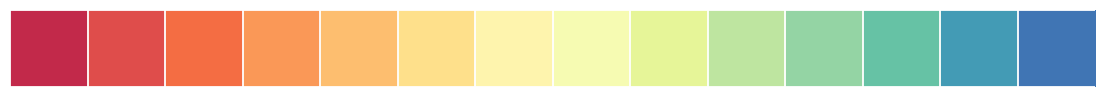

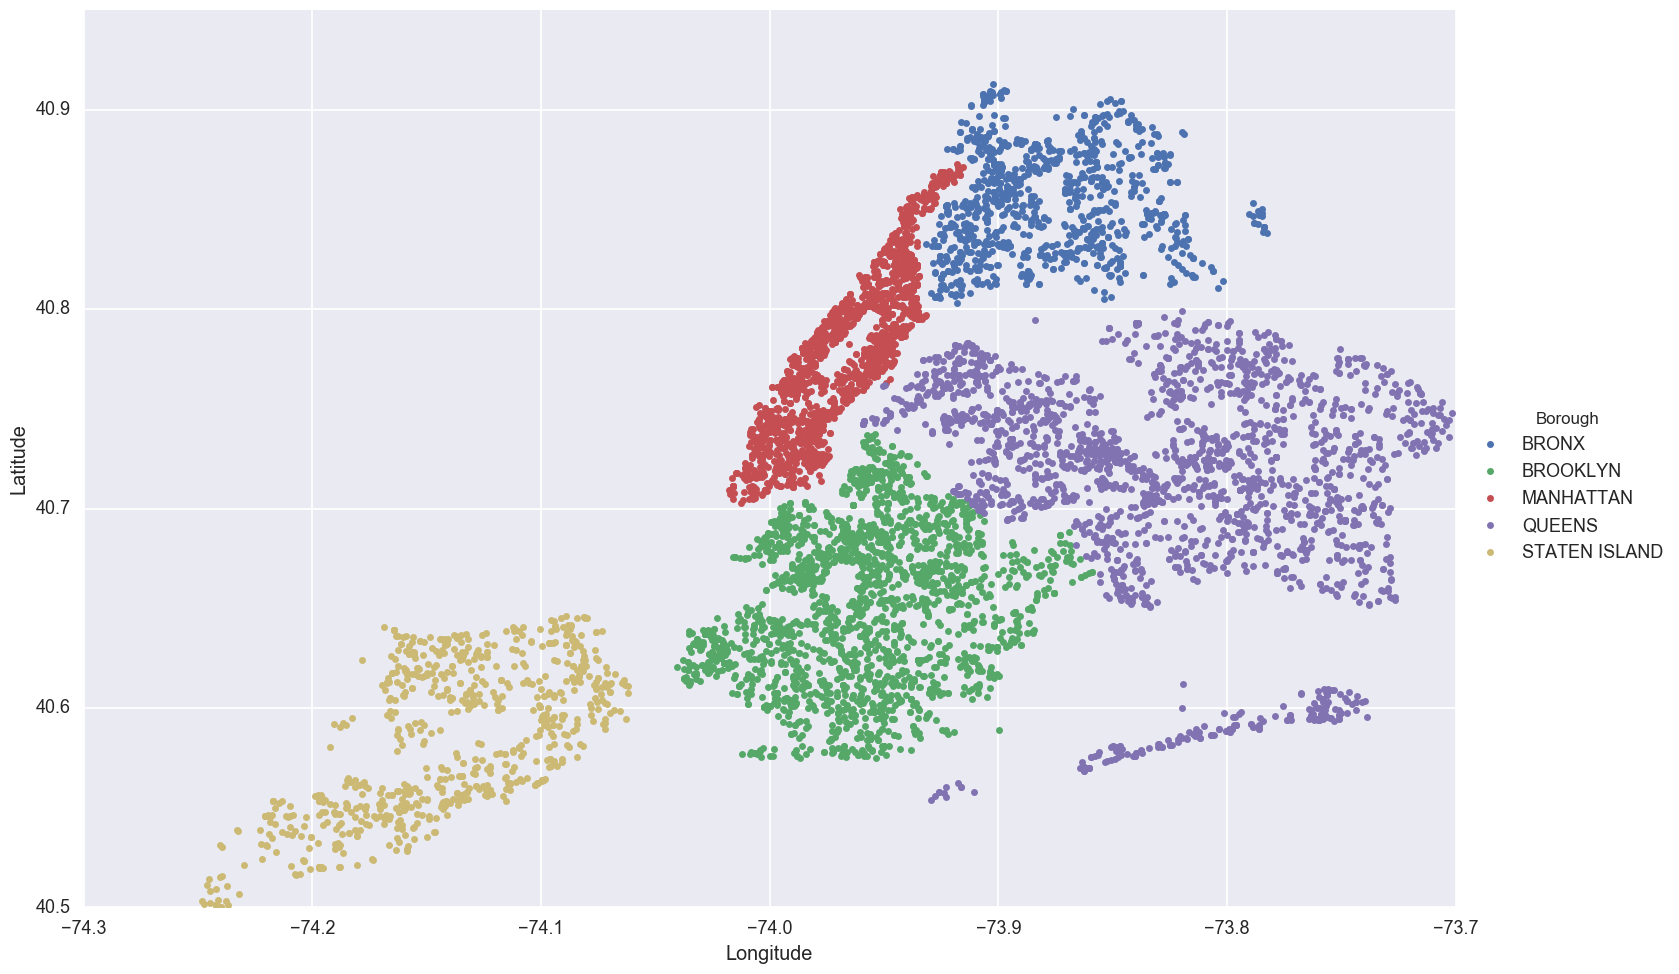

In [35]:
# fig = plt.gcf()
palplot = sns.palplot(sns.color_palette('Spectral',14));
fg = sns.FacetGrid(data=df.sort_values(by='Borough'), hue='Borough', size = 10, aspect=1.5)
mapped = fg.map(plt.plot, 'Longitude', 'Latitude',linestyle='', marker='o', markersize=5).add_legend()
context = sns.set_context("talk")
# fig.savefig('by_location_colorByBorough.png')
# fig = mapped.get_figure()
# plt.tight_layout()
# fig = palplot.get_figure()
# fig = fg.get_figure()
# fig = mapped.get_figure()
# fig = context.get_figure()
# fig.savefig('by_location_colorByBorough.png')
fg.savefig('by_location_colorByBorough.png', bbox_inches='tight')

We might want to see if any of these boroughs has dramatically more complaints than another.  
To address that, we can start by getting the counts of complaints by borough, and visualizing them as a bar plot: 

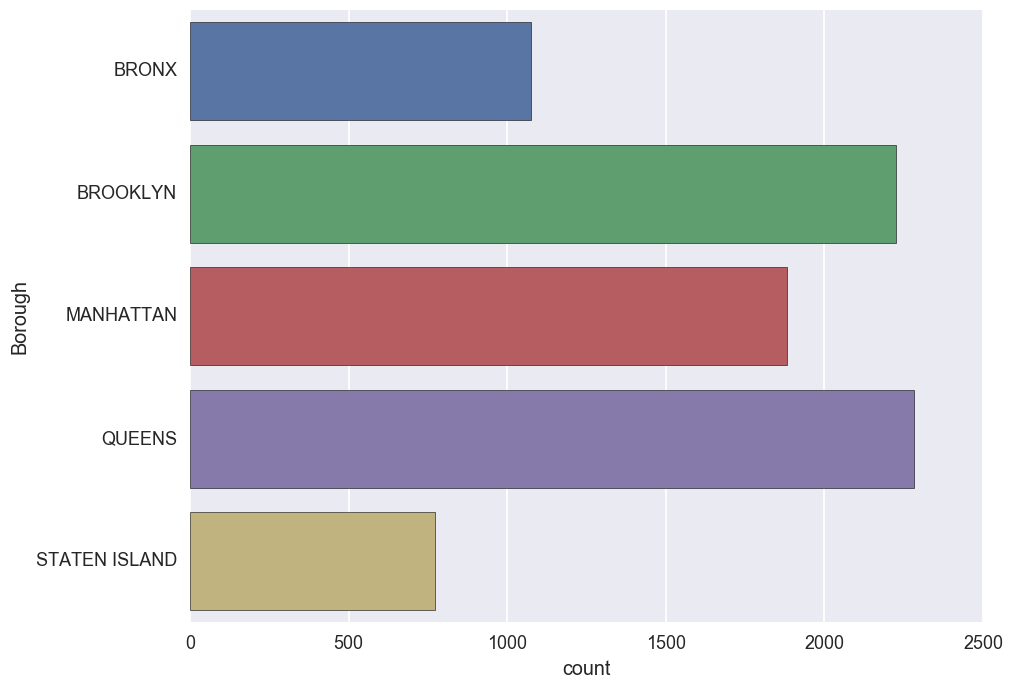

In [36]:
countplot = sns.countplot(y='Borough',
              data=df.sort_values(by='Borough'))
sns.set_context("talk")
fig = countplot.get_figure()
plt.tight_layout()
fig.savefig('complaint_count_byBorough.png')

We might wonder if certain areas are more prone to certain types of complaints.  We can use the "Descriptor" column to color-code the datapoints and we get a map like this:

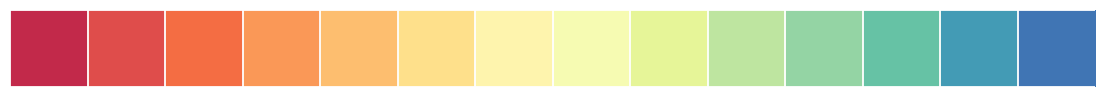

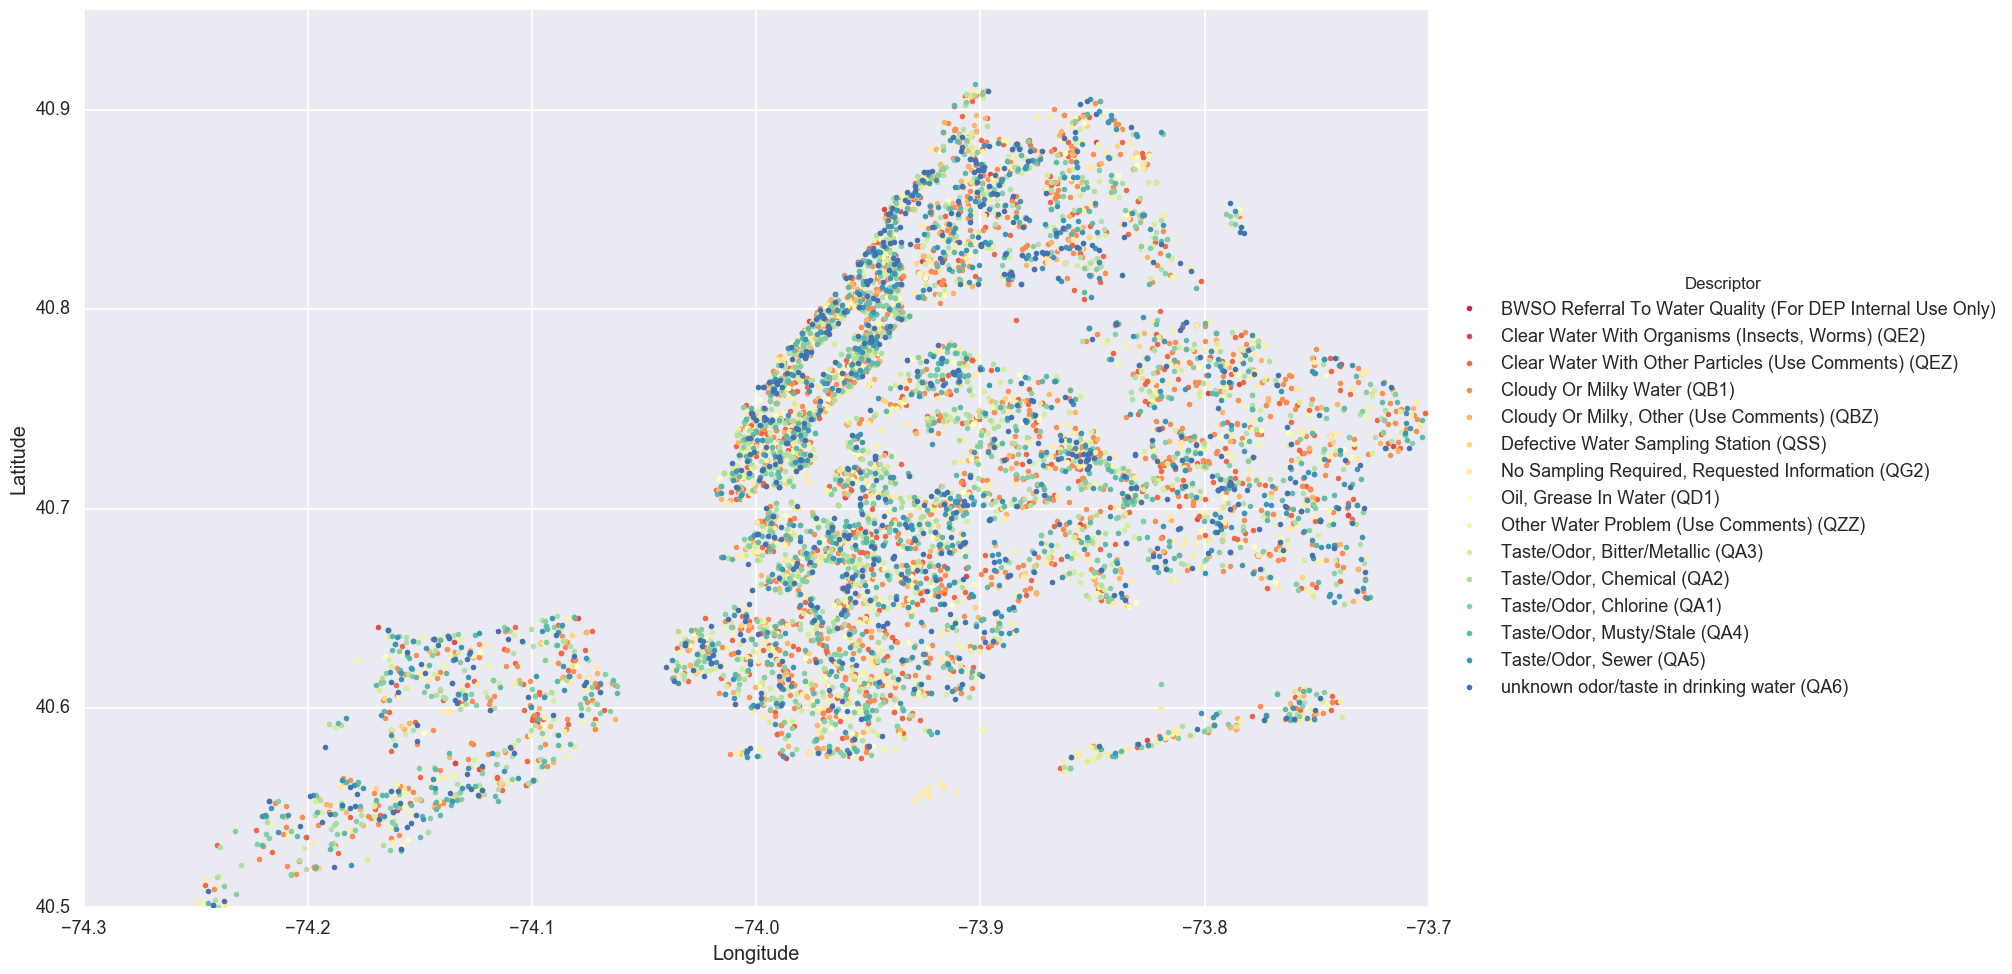

In [37]:
sns.palplot(sns.color_palette('Spectral',14));
fg = sns.FacetGrid(data=df, hue='Descriptor', 
                   hue_order=sorted(df['Descriptor'].unique()),
                   palette="Spectral", size = 10, aspect=1.5)
fg.map(plt.plot, 'Longitude', 'Latitude',linestyle='', marker='o', markersize=4).add_legend()
# plt.tight_layout()
fg.savefig('byLocation_ColorByDescriptorAll.png')

From this color-coded plot, it appears that Manhattan and nearby areas of Brooklyn and Queens have a high density of taste/odor complaints (bluer colors). However, it's hard to really see the breakdown just from this plot, given the high density of complaints in certain areas.  We can break it down into subplots by borough: 

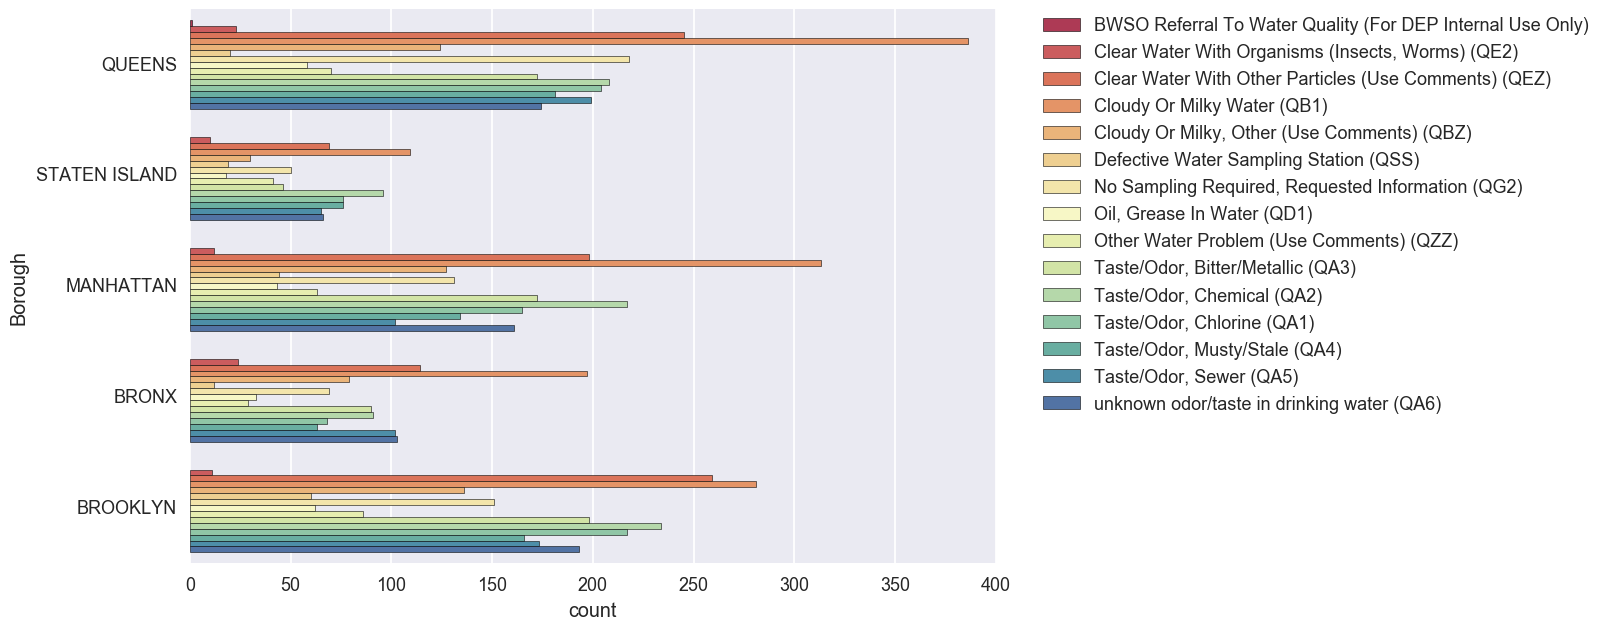

In [38]:
countPlot = sns.countplot(y='Borough', hue = 'Descriptor', 
              data=df.sort_values(by='Descriptor'), 
              palette = sns.color_palette('Spectral',len(df['Descriptor'].unique())))
art = []
lgd = plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
art.append(lgd)
# sns.set_context("talk")
# plt.tight_layout()
fig = countPlot.get_figure()
fig.savefig('barByBorough_ColorByDescriptorAll.png', additional_artists=art,
    bbox_inches="tight")

### If we only plot water complaints that sound similar to brown water, we get: 

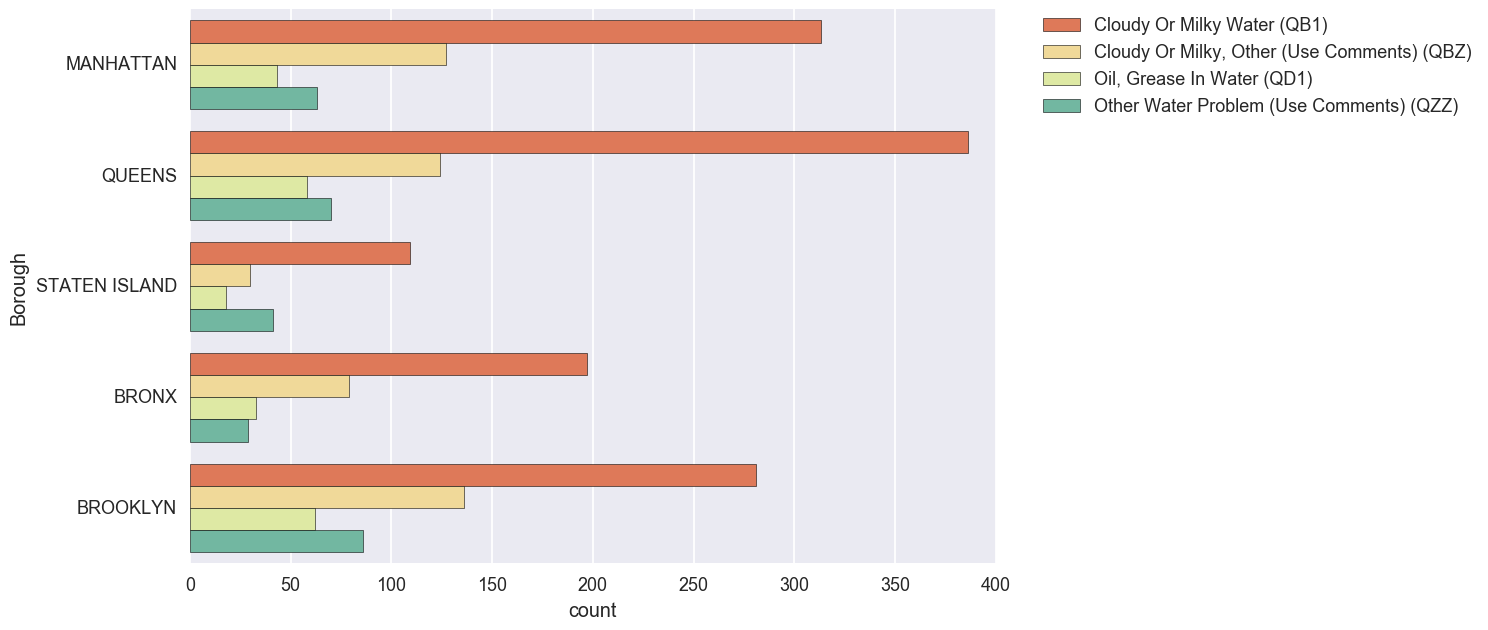

In [39]:
# Select the issue descriptions we want to plot:
partialDescList = [
 'Cloudy Or Milky Water (QB1)', 
 'Cloudy Or Milky, Other (Use Comments) (QBZ)', 
 'Oil, Grease In Water (QD1)', 
 'Other Water Problem (Use Comments) (QZZ)'
]

sns.countplot(y='Borough', hue = 'Descriptor', 
              data=df[df['Descriptor'].isin(partialDescList)].sort_values(by='Descriptor'), 
              palette = sns.color_palette('Spectral',len(partialDescList)))
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
sns.set_context("talk")

## Seems like we see a good number of complaints in all boroughs, and definitely see barrier islands as well. 

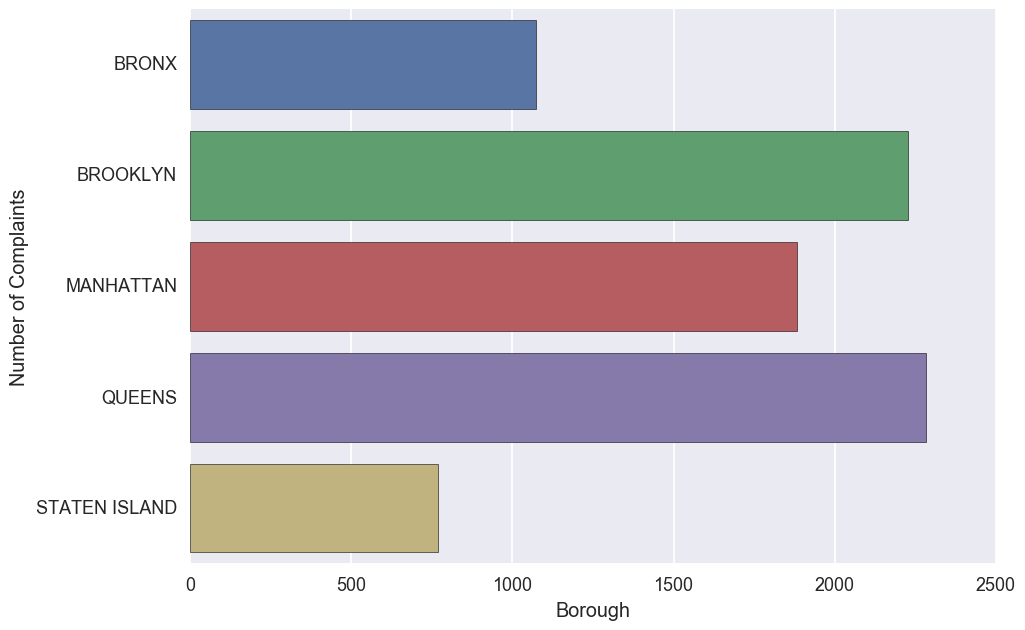

In [40]:
# Let's get a bar plot to see which areas have the most complaints. 
sns.countplot(y='Borough',
              data=df.sort_values(by='Borough'))
sns.set_context("talk")

plt.ylabel('Number of Complaints')
plt.xlabel('Borough')
sns.despine()

In [41]:
# We would like to normalize to the population of each borough.  
# We have census population data from 2010 (and 2000) in the dataframe 'census'.  

bCounts = df['Borough'].value_counts().sort_index()
bCounts

BRONX            1074
BROOKLYN         2227
MANHATTAN        1882
QUEENS           2283
STATEN ISLAND     771
Name: Borough, dtype: int64

In [42]:
census['Borough'] = census['Borough'].str.upper()
census

,Borough,2000 Population,2010 Population
0,BRONX,1332650,1385108
1,BROOKLYN,2465326,2504700
2,MANHATTAN,1537195,1585873
3,QUEENS,2229379,2230722
4,STATEN ISLAND,443728,468730


In [43]:
censusBor = census.set_index('Borough')
censusBor

,2000 Population,2010 Population
Borough,,
BRONX,1332650,1385108
BROOKLYN,2465326,2504700
MANHATTAN,1537195,1585873
QUEENS,2229379,2230722
STATEN ISLAND,443728,468730


In [44]:
# bCountsNorm = bCounts/censusBor['2010 Population']
# bCountsNorm


In [45]:
boroughComplaintsNormBy2010Pop = df['Borough'].value_counts().sort_index()/censusBor['2010 Population']
# boroughComplaintsNormBy2010Pop.columns = ["Borough", "NormalizedCount"]
boroughComplaintsNormBy2010Pop

BRONX            0.000775
BROOKLYN         0.000889
MANHATTAN        0.001187
QUEENS           0.001023
STATEN ISLAND    0.001645
dtype: float64

I wanted to normalize this to the population per borough, so I also downloaded NYC OpenData's census table as a csv. 

After dividing each borough's complaints count by the 2010 census population for that borough (one could argue that a more recent population estimate would have been better, but the 2010 census should be an OK approximation), we get the updated bar plot:  

BRONX            0.000775
BROOKLYN         0.000889
MANHATTAN        0.001187
QUEENS           0.001023
STATEN ISLAND    0.001645
dtype: float64

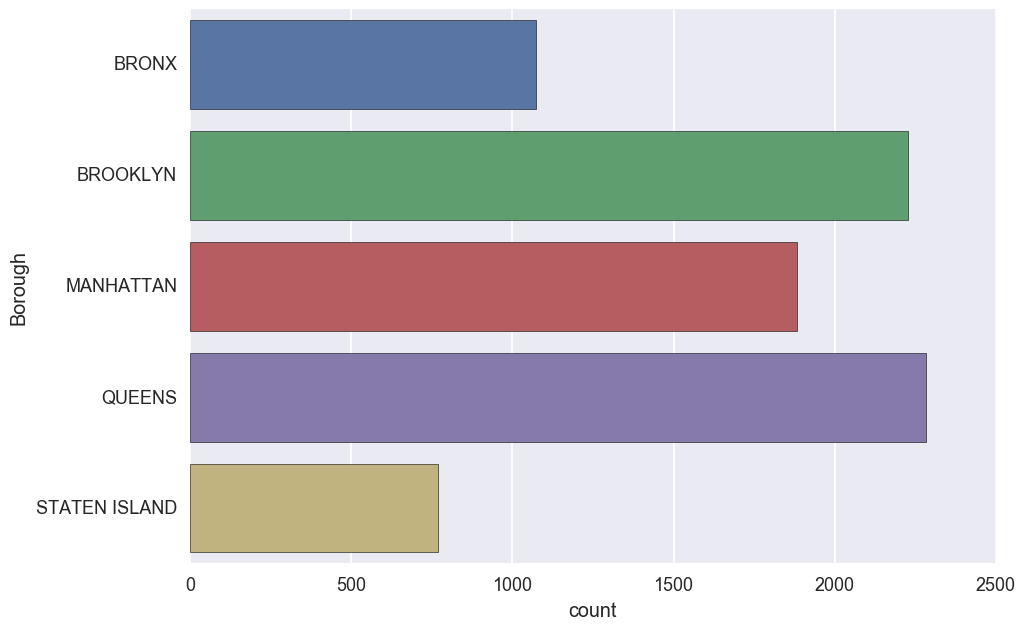

In [46]:
sns.countplot(y='Borough',
              data=df.sort_values(by='Borough'))
sns.set_context("talk")
boroughComplaintsNormBy2010Pop

In [47]:
df['Borough'].unique()

array(['BROOKLYN', 'MANHATTAN', 'BRONX', 'QUEENS', 'STATEN ISLAND'], dtype=object)

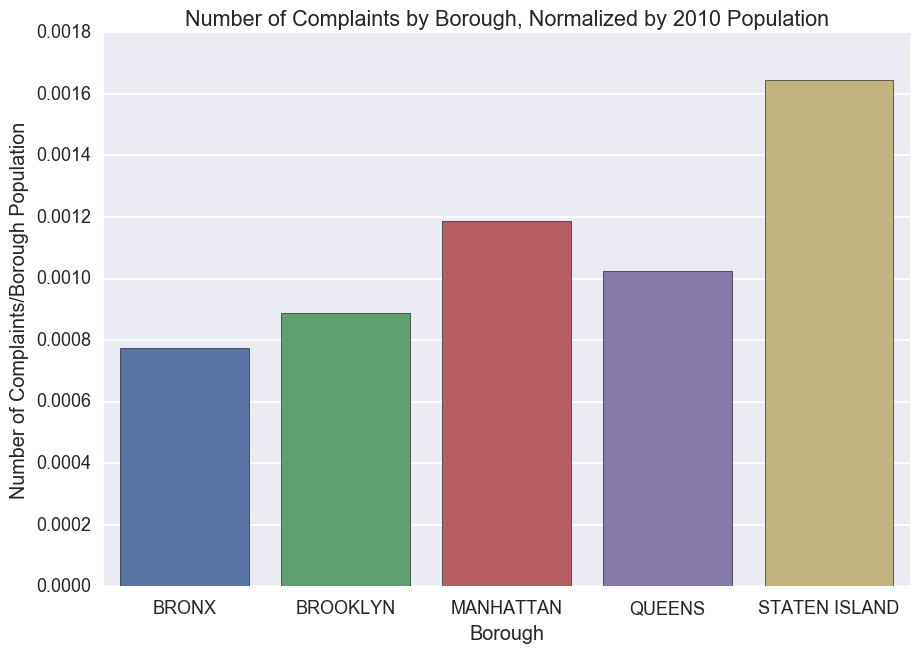

In [48]:
# Let's get a bar plot to see which areas have the most complaints, normalized by population.
xpos = sorted(df['Borough'].unique())
barplot = sns.barplot(x = xpos, y=boroughComplaintsNormBy2010Pop)

fig = barplot.get_figure()
plt.ylabel('Number of Complaints/Borough Population')
plt.xlabel('Borough')
plt.title('Number of Complaints by Borough, Normalized by 2010 Population')
plt.show()  
fig.savefig('NumComplaintsByBoroughNormBy2010Pop.png')

Now we can see that when we adjust for population, Staten Island has the most water quality complaints. 

### Water Complaints Over Time

Zooming in to see what's below those outliers: 


Seeing what we get when we optimize a cosine function to fit the data from December 2013 to December 2016 (the latter half of the data, which seemed to have fewer outliers): 



 



It looks like there is some periodicity, but it's not highly pronounced (the amplitude of our optimized curve is pretty low).  It looks like on average there are about 4 complaints per day, and that doesn't seem to be highly dependent on what time of year it is.  Perhaps it takes a really serious water problem to get New Yorkers to call in, and those don't happen seasonally.  Probably indicative of a well maintained water supply system!

Note: Some of the calls were requests for information ("No sampling required..."), and these entries should be removed and the data reanalyzed.  May also want to color points on lat/long plot to see if certain types of complaints come mainly from certain areas (also certain times is of interest).  Can probably use a dummy variable from the call notes for this.  Or without a dummy var, a nice way to do this with seaborn is shown here: 

Future question: How does this periodicity (or lack thereof) compare to water quality at the beaches, which we might expect to be much more seasonal (due to e.g. increased growth of bacteria during warmer months). 




In [49]:
df['Created Date'] = pd.to_datetime(df['Created Date'])

all_dates = df['Created Date'] # Get the date when each incident was created (reported)
all_dates[0:5]

0   2015-09-10
1   2015-09-15
2   2015-09-16
3   2015-09-16
4   2015-09-18
Name: Created Date, dtype: datetime64[ns]

In [50]:
# Generate a dataframe from the value counts of number of complaints on each day: 
dateCounts = pd.DataFrame(all_dates.value_counts().reset_index())
dateCounts.columns = ['dates','countsOnDate']
dateCounts['dates'].head()

0   2013-04-29
1   2012-05-29
2   2012-09-24
3   2012-05-31
4   2012-11-23
Name: dates, dtype: datetime64[ns]

In [51]:
dateCounts2 = dateCounts
dateCounts2['dates'] = pd.to_datetime(dateCounts['dates'])
dateCounts2 = dateCounts.set_index('dates')
dateCounts2[0:5]


,countsOnDate
dates,
2013-04-29,41
2012-05-29,24
2012-09-24,18
2012-05-31,14
2012-11-23,13


## Sources

Data: <br>
NYC OpenData's Water Quality complaints (Originally retrieved 3/12/2017).<br>
New York City Population By Boroughs (Retrieved 5/13/2017).

Tips: <br>
Thanks to Dhara at http://stackoverflow.com/questions/16716302/how-do-i-fit-a-sine-curve-to-my-data-with-pylab-and-numpy, for a great demo on how to fit a sine/cosine function using python. <br>
Coloring by column values: Paul H via http://stackoverflow.com/questions/14885895/color-by-column-values-in-matplotlib. <br>
Many general plotting tips: https://python-graph-gallery.com/134-how-to-avoid-overplotting-with-python/. <br>
Value counts: AryanJ-NYC and EdChum on StackOverflow. <br>
Moving legend outside of figure: https://stackoverflow.com/questions/30490740/move-legend-outside-figure-in-seaborn-tsplot.<br>
Time Series Decomposition function: AN6U5 on StackOverflow at http://stackoverflow.com/questions/20672236/time-series-decomposition-function-in-python. <br>
Binning time series over certain periods: https://stackoverflow.com/questions/39002122/binning-time-series-with-pandas. <br>